<a href="https://colab.research.google.com/github/omkardpatil/conformal_cooling_channels_design_optimization/blob/main/GA_custom_cut_FE_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
import fenics
from fenics import *
from mshr import *
from math import *
clear_output()

In [ ]:
# define cut boundary from domain
# smallest unit 0.1*0.1
# define domain -0.9 to +0.9 in  x and y
# constrains continuous cut only in x and y ie not diagonal
# number of cuts 1

In [ ]:
# major hyper parameter defines number of squares that will fit in 1.8 unit from -0.9 to +0.9
size=8

In [ ]:
#domain to cut -0.9 to +0.9
# 18*18
# -0.9+0.1*i

def get_mesh(remove):
  domain = Rectangle(Point(-1.0,-1.0), Point(1.,1.))
  l,w = remove.shape
  m=1.8/w
  for i in range(l):
    for j in range(w):
      if(remove[i,j]):
        domain = domain - Rectangle(Point(-0.9+m*i,-0.9+m*j), Point(-0.9+m*(i+1),-0.9+m*(j+1)))
  mesh = generate_mesh ( domain, 10 )
  return mesh

In [ ]:
import numpy as np
def get_matrix(size):
  remove = np.zeros((size,size))
  remove[2][2]=1
  remove[1][0]=1
  remove[2][1]=1
  remove[1][2]=1
  return remove

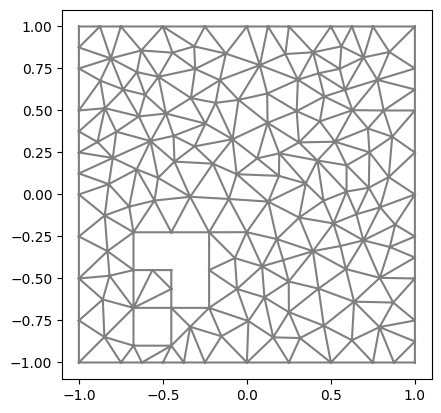

In [ ]:
remove = get_matrix(size)
mesh = get_mesh(remove)
plot(mesh)

In [ ]:
def work(mesh, u):
  # Define your mesh and function space
  V = FunctionSpace ( mesh, "Lagrange", 1 )

  # Create a function to interpolate 'u' to the function space
  u_interpolated = interpolate(u, V)

  # Get the values of 'u' at all nodes
  u_values = u_interpolated.vector().get_local()
  np_u = np.array(u_values)
  # Use np.ceil to round up each element to the nearest integer
  integer_array = np.ceil(np_u).astype(int)
  unique_elements, counts = np.unique(integer_array, return_counts=True)
  element_count_dict = dict(zip(unique_elements, counts))
  fitness=0
  for i, j in element_count_dict.items():
      r=i-temp_threshold_for_fitness
      if(r>0):
          fitness+=(j*j*r)
  return fitness

In [ ]:
import math
def is_point_near_square(point, square_bottom_left, edge_length,m):
    square_center = (
        square_bottom_left[0] + edge_length / 2,
        square_bottom_left[1] + edge_length / 2
    )

    distance = math.sqrt(
        (point[0] - square_center[0]) ** 2 +
        (point[1] - square_center[1]) ** 2
    )

    return distance < edge_length*m

In [ ]:
remove = get_matrix(size)
multiplyer=0.72
def on_edge(x):
    l,w = remove.shape
    m=1.8/w
    edge_length=m
    for i in range(l):
      for j in range(w):
        if(remove[i][j]):
          square_bottom_left=[-0.9+m*i,-0.9+m*j]
          ans= is_point_near_square(x, square_bottom_left, edge_length, multiplyer)
          if ans:
            return True
    return False

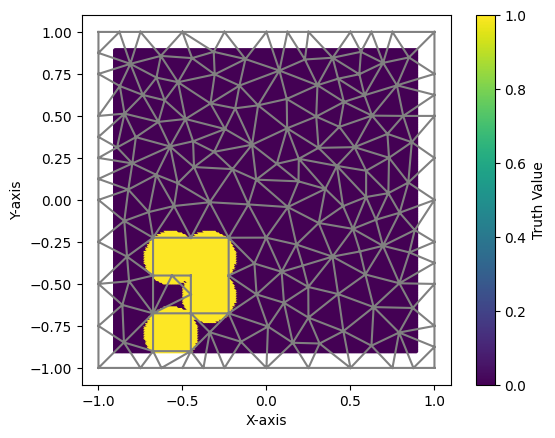

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

my_array = np.arange(-0.9, 0.9, 0.01)
x, y = np.meshgrid(my_array, my_array)
points = np.column_stack((x.ravel(), y.ravel()))

c_values=np.zeros(points.shape[0])
i=0
for point in points:
  c_values[i] = on_edge(point)
  i=i+1

point_size=5
plt.scatter(*zip(*points), c=c_values, cmap='viridis',  s=point_size)
plot(mesh)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.colorbar(label='Truth Value')
plt.show()

In [ ]:

def work(mesh, u):
  # Define your mesh and function space
  V = FunctionSpace ( mesh, "Lagrange", 1 )
  # Create a function to interpolate 'u' to the function space
  u_interpolated = interpolate(u, V)
  # Get the values of 'u' at all nodes
  u_values = u_interpolated.vector().get_local()
  np_u = np.array(u_values)
  # Use np.ceil to round up each element to the nearest integer
  integer_array = np.ceil(np_u).astype(int)
  unique_elements, counts = np.unique(integer_array, return_counts=True)
  element_count_dict = dict(zip(unique_elements, counts))
  fitness=0
  j_count=0
  for i, j in element_count_dict.items():
      r=i-temp_threshold_for_fitness
      if(r>0):
          fitness+=(j*j*r)
      j_count+=j
  fitness3 =exp(-j_count*1)-1
  return fitness*fitness3

In [ ]:
from fenics import *
from mshr import *
from math import *
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

temp_threshold_for_fitness=35
temp_threshold_for_stopping=50
t0=0.2 #time for which hot plastic will be in contact
#  Define time things
t_init = 0.0
t_final = 3.0
t_num = 100

def heat_implicit (remove_):

  mesh = get_mesh(remove_)

  V = FunctionSpace ( mesh, "Lagrange", 1 )

  #rectangle
  rect_u = 150.0
  def rect_on ( x, on_boundary ):
    return ( on_boundary and near(x[1],1))
  rect_bc = DirichletBC ( V, rect_u, rect_on )

  #edge
  fluid_u = 20.0
  fluid_bc = DirichletBC ( V, fluid_u, on_edge)
  bc_new = [fluid_bc]
  bc = [fluid_bc, rect_bc]

#  Define the trial functions (u) and test functions (v).
  u = TrialFunction ( V )
  v = TestFunction ( V )


#  The diffusivity is a constant.
  k = Constant ( 1.0 )
#  The source term is zero.
  f = Constant ( 0.0 )
  dt = ( t_final - t_init ) / t_num

#  Create U_INIT.
  u_init = Expression ( "40.0", degree = 10 )
  u_old = interpolate ( u_init, V )
  fvt = ( u_old + dt * f ) * v * dx
  Auvt = u * v * dx + dt * dot ( grad(u), grad(v) ) * dx
  u = Function ( V )
  t = t_init
  v_min=20
  v_max=150
  for j in range ( 0, t_num + 1):
    t = t + dt
    #print(t, work(mesh, u))
    if(t>t0):
      bc=bc_new
    solve ( Auvt == fvt, u, bc )

    u_old.assign ( u )
    max_value = u.vector().max()
    if(max_value<temp_threshold_for_stopping):
      fitness1 = work(mesh, u)
      fitness2 = exp(t)
      return fitness1*fitness2, u_old, mesh
  fitness1 = work(mesh, u)
  fitness2 = exp(t)
  return fitness1*fitness2

def heat_implicit_test (remove):
  level = 30
  set_log_level ( level )
  ans =  heat_implicit(remove)
  if(type(ans) is tuple):
    ans=ans[0]
  return ans

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage  # Add this line

def generate_matrix(size):
    return np.random.choice([0, 1], size=(size, size), p=[0.7, 0.3])

def plot_matrix(ax, matrix, title):
    ax.imshow(matrix, cmap='viridis', interpolation='nearest')
    ax.set_title(title)

def remove_islands(matrix):
    labeled_matrix, num_labels = label_islands(matrix)
    for label in range(1, num_labels + 1):
        if not has_water_border(labeled_matrix, label):
            matrix[labeled_matrix == label] = 0
    return matrix

def reverse_y_axis(matrix):
    reversed_matrix = matrix[::-1]
    return reversed_matrix

def label_islands(matrix):
    labeled_matrix, num_labels = ndimage.label(matrix)
    return labeled_matrix, num_labels

def has_water_border(labeled_matrix, label):
    return any(labeled_matrix[0, :] == label) or any(labeled_matrix[-1, :] == label) or \
           any(labeled_matrix[:, 0] == label) or any(labeled_matrix[:, -1] == label)


def get_matrix2(size, to_plot):
  # Generate and plot the initial matrix
  initial_matrix = generate_matrix(size)
  if(to_plot):
    reversed_matrix = reverse_y_axis(initial_matrix)
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    plot_matrix(axs[0], reversed_matrix, 'Before Removing Islands')
    result_matrix = remove_islands(reversed_matrix)
    plot_matrix(axs[1], result_matrix, 'After Removing Islands')
    plt.show()
    remove = reverse_y_axis(result_matrix)
  else:
    reversed_matrix = reverse_y_axis(initial_matrix)
    result_matrix = remove_islands(reversed_matrix)
    remove = reverse_y_axis(result_matrix)
  return remove

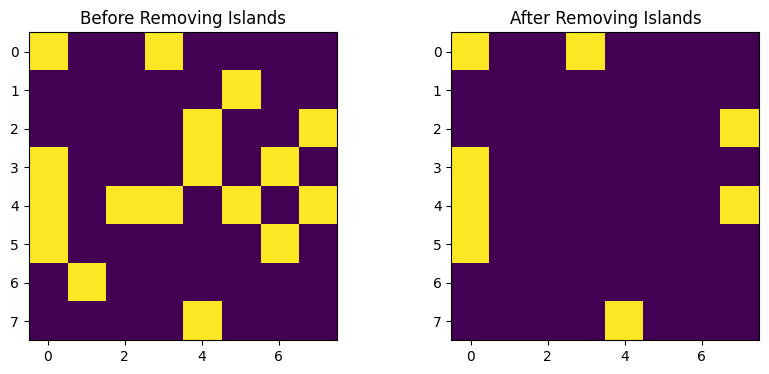

In [ ]:
remove_ = get_matrix2(size, True)

In [ ]:
ans = heat_implicit_test (remove_)
print(ans)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00644231 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.174413 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:----------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_e48e7c9e2c1fcd85cb094c346146399f2ce85504

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    2
  Coefficients:              '[f_79, f_81]'
  Unique elements:           'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0707715 seconds.

INFO:FFC:Compiler st

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_4f750817ecc896f3bedcb4ff8c9f3352153b1b38

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00359249 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0156651 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_17d5bd7e022a45e71c9f390bd00f3f09885a1fd0

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00495625 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0181181 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_3720490578293ae8ad5feabedc46584f48fda4c4

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00502563 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0117085 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_870c5bde676a876313d11614d74a70086ef82fbc

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0586956 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-----------------------------

-22423.094049792588


In [ ]:
import numpy as np

# Define the size of the matrix
size = 8
max_fitness_list=[]
avg_fitness_list=[]
circles_list = []

# Define the fitness function (you can customize this based on your specific requirements)
def fitness(matrix):
    # Example fitness function: Count the number of 1's in the matrix
    ans = heat_implicit_test (matrix)
    count_0 = np.count_nonzero(matrix == 0)
    return ans*count_0 #-np.sum(matrix)

# Initialize a population of binary matrices
def initialize_population(population_size, matrix_size):
    a = np.random.randint(2, size=(population_size, matrix_size, matrix_size))
    for i in range(population_size):
      a[i] = get_matrix2(matrix_size, False)
    return a

# Select parents based on their fitness
def select_parents(population, fitness_values):
    probabilities = fitness_values / fitness_values.sum()
    selected_indices = np.random.choice(len(population), size=2, p=probabilities)
    return population[selected_indices]

# Crossover operation (single-point crossover)
def crossover(parents):
    crossover_point = np.random.randint(1, len(parents[0].ravel()))
    child = np.concatenate([parents[0][:crossover_point], parents[1][crossover_point:]])
    return child.reshape(parents[0].shape)

# Mutation operation (flip a random bit)
def mutate(child, mutation_rate):
    if np.random.rand() < mutation_rate:
        mutation_point = np.random.randint(len(child.ravel()))
        child.ravel()[mutation_point] = 1 - child.ravel()[mutation_point]
        child = remove_islands(child)
        print("^----- mutation occured here")
    return child

# Genetic Algorithm
def genetic_algorithm(population_size, generations, mutation_rate):
    population = initialize_population(population_size, size)
    for generation in range(generations):
        #clear_output()
        print(generation)
        fitness_scores = [fitness(individual) for individual in population]

        # Record best and average fitness values for the current generation
        max_fitness_list.append(max(fitness_scores))
        avg_fitness_list.append(np.mean(fitness_scores))


        fitness_values = np.array([fitness(matrix) for matrix in population])
        parents = select_parents(population, fitness_values)
        child = crossover(parents)
        child = mutate(child, mutation_rate)
        population[np.argmax(fitness_values)] = child

    best_matrix = population[np.argmax(fitness_values)]
    return best_matrix

# Example usage
np_ = 20
ng = 51
mr = 0.2
best_matrix = genetic_algorithm(population_size=np_, generations=ng, mutation_rate=mr)
clear_output()
print("Best Matrix:")
print(best_matrix)
print("Fitness:", fitness(best_matrix))

Best Matrix:
[[0 1 1 1 0 0 0 1]
 [0 0 0 1 0 0 0 0]
 [0 0 0 1 1 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [1 1 0 0 1 0 0 0]]
Fitness: -6231312.192034413


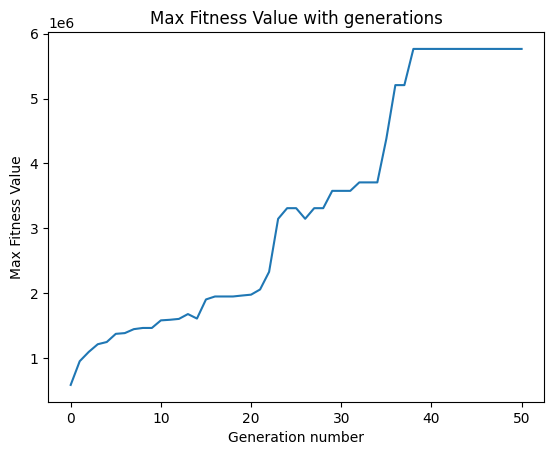

In [ ]:
import matplotlib.pyplot as plt

# Your array data
data = max_fitness_list
data = -np.array(data)

# Plotting
plt.plot(data)

# Adding labels
plt.xlabel('Generation number')
plt.ylabel('Max Fitness Value')
plt.title('Max Fitness Value with generations')

# Display the plot
plt.show()

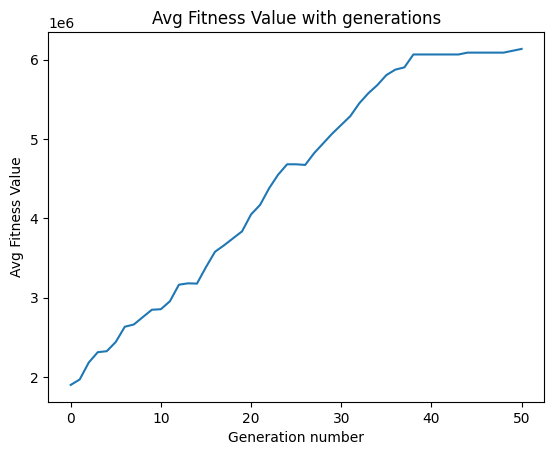

In [ ]:
import matplotlib.pyplot as plt

# Your array data
data = avg_fitness_list
data = -np.array(data)

# Plotting
plt.plot(data)

# Adding labels
plt.xlabel('Generation number')
plt.ylabel('Avg Fitness Value')
plt.title('Avg Fitness Value with generations')


# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def plot_binary_matrix(matrix):
    plt.imshow(matrix, cmap='binary', interpolation='nearest')
    plt.title("1/Black is air & 0/White is solid")
    plt.colorbar()
    plt.show()

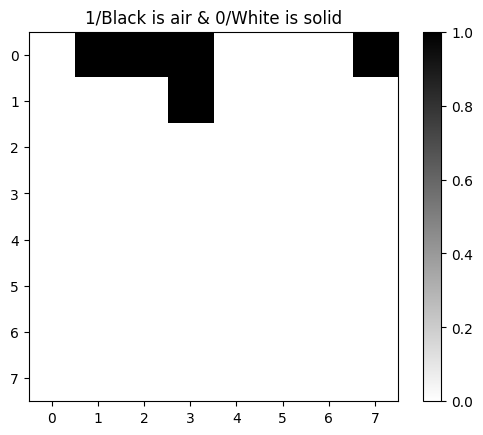

-59788.93548418956


In [ ]:
matrix= best_matrix
ans = heat_implicit_test (matrix)
plot_binary_matrix(matrix)
print(ans)